<div align="center"; span style="color:#336699"><b><h2> Algorithm Workflow </h2></b></div>
<hr style="border:2px solid #0077b9;">
<br/>
<div style="text-align: center;font-size: 90%;">
    Helvécio B. Leal Neto, <sup><a href="https://orcid.org/0000-0002-7526-2094"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    Alan J. P. Calheiros<sup><a href="https://orcid.org/0000-0002-7526-2094"><i class="fab fa-lg fa-orcid" style="color: #a6ce39"></i></a></sup>
    <br/><br/>
    National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Contact: <a href="mailto:helvecio.neto@inpe.br">helvecio.neto@inpe.br</a>, <a href="mailto:alan.calheiros@inpe.br">alan.calheiros@inpe.br</a>
    <br/><br/>
    Last Update: Nov 1, 2024
</div>
<br/>
<div style="text-align: justify;  margin-left: 25%; margin-right: 25%;">
<b>Abstract.</b> This Jupyter notebook demonstrates the complete processing flow of the tracking process of pyForTraCC algorithm. There you can check the example of tracking using radar data.
</div>    
<br/>
<div style="text-align: justify;  margin-left: 15%; margin-right: 15%;font-size: 75%; border-style: solid; border-color: #0077b9; border-width: 1px; padding: 5px;">
    <b>This Jupyter Notebook was based on the <a href="https://github.com/fortracc-project/pyfortracc">"pyfortracc"</a> example from the pyFortracc:</b>
    <div style="margin-left: 10px; margin-right: 10px; margin-top:10px">
      <p> Leal Neto, H.B.; Calheiros, A.J.P.;  pyForTraCC Algorithm. São José dos Campos, INPE, 2024. <a href="https://github.com/fortracc-project/pyfortracc" target="_blank"> Online </a>. </p>
    </div>
</div>

### Schedule

 [1. Installation](#install)<br>
 [2. Radar Input Data](#data)<br>
 [3. Read Function](#read)<br>
 [4. Tracking Parameters](#parameters)<br>
 [5. Algorithm Workflow](#parameters)<br>
 [- Features Extraction](#features)<br>
 [- Spatial Operations](#spatial)<br>
 [- Cluster Link](#link)<br>
 [6. Explore Output](#output)

<a id='install'></a>
#### 1. Installation

Installing the pyFortraCC package can be done using the pip install command. 

All dependencies will be installed in the current Python environment and the code will be ready to use.

In [1]:
# Install directly from github
!pip3 install --upgrade git+https://github.com/fortracc/pyfortracc.git@main#egg=pyfortracc &> /dev/null

<a id='data'></a>
#### 1. Radar Input Data

The data in this example corresponds to a small sample of scans from the S-Band Radar located in the city of Manaus-AM Brazil.<br>
 Data processed and published by Schumacher, Courtney and Funk, Aaron (2018) were separated, <br>
 and are available in full on the ARM platform https://www.arm.gov/research/campaigns/amf2014goamazon.<br>
 This data is part of the GoAmazon2014/5 project and is named "Three-dimensional Gridded S-band Reflectivity and Radial Velocity<br>
 from the SIPAM Manaus S-band Radar dataset".<br>
https://doi.org/10.5439/1459573


In [2]:
# Download the exemple input files
!pip3 install --upgrade --no-cache-dir gdown &> /dev/null
!gdown 'https://drive.google.com/uc?id=1UVVsLCNnsmk7_wOzVrv4H7WHW0sz8spg'
!unzip -qq -o input.zip
!rm -rf input.zip

Downloading...
From (original): https://drive.google.com/uc?id=1UVVsLCNnsmk7_wOzVrv4H7WHW0sz8spg
From (redirected): https://drive.google.com/uc?id=1UVVsLCNnsmk7_wOzVrv4H7WHW0sz8spg&confirm=t&uuid=055d5bcb-0a67-4d2f-b5fc-06fe7ad9ec70
To: /home/helvecioneto/pyfortracc/examples/02_Algorithm_Workflow_Radar_Example/input.zip
100%|██████████████████████████████████████| 68.6M/68.6M [00:06<00:00, 10.3MB/s]


<a id='read'></a>
#### 3. Read Function

The downloaded data is compressed with the .gz extension, however, it is of the netCDF4 type. The variable that represents reflectivity is DBZc. This data also has multiple elevations, and we arbitrarily chose elevation 5, which corresponds to the volumetric scan level at 2.5 km height. We extract the data and apply a NaN value to the data mask -9999.

In [3]:
# Define the Read function
import gzip
import netCDF4
import numpy as np

def read_function(path):
    variable = "DBZc"
    z_level = 5 # Elevation level 2.5 km
    with gzip.open(path) as gz:
        with netCDF4.Dataset("dummy", mode="r", memory=gz.read()) as nc:
            data = nc.variables[variable][:].data[0,z_level, :, :][::-1, :]
            data[data == -9999] = np.nan
    gz.close()
    return data

In [4]:
# Import the pyfortracc package
import pyfortracc

In [5]:
# Visualize the data
pyfortracc.plot_animation(path_files='input/*.gz', 
                          num_frames=10, min_val=-10, max_val=60,
                          read_function=read_function,  cbar_title='dBZ')

Generating animation... 

<a id='parameters'></a>
#### 4. Tracking Parameters

For this example, we will track reflectivity clusters at multiple thresholds and sizes <br>Arbitrarily selecting thresholds of 20, 30 and 35 dBZ with clusters of 5,4 and 3 pixels <br>of minimum size. The segmentation operator will be >=, that is, the clusters will be <br>segmented in order of greatest equal for each threshold and the delta of the observations <br>is 12 minutes. The clustering algorithm in this example will be DBSCAN and the overlap <br>rate between clusters of consecutive times will be 20%.

In [6]:
# Example Name list dictionary of mandatory parameters
name_list = {}
name_list['input_path'] = 'input/' # path to the input data
name_list['output_path'] = 'output/' # path to the output data
name_list['timestamp_pattern'] = 'sbmn_cappi_%Y%m%d_%H%M.nc.gz' # timestamp file pattern
name_list['thresholds'] = [20,30,35] # in dbz
name_list['min_cluster_size'] = [3,3,3] # in number of points per cluster
name_list['operator'] = '>=' # '>= - <=' or '=='
name_list['delta_time'] = 12 # in minutes
name_list['cluster_method'] = 'dbscan' # DBSCAN Clustering method
name_list['min_overlap'] = 20 # Minimum overlap between clusters in percentage

# Optional parameters, if not set, the algorithm will not use geospatial information
name_list['lon_min'] = -62.1475 # Min longitude of data in degrees
name_list['lon_max'] = -57.8461 # Max longitude of data in degrees
name_list['lat_min'] = -5.3048 # Min latitude of data in degrees
name_list['lat_max'] = -0.9912 # Max latitude of data in degrees

<a id='workflow'></a>
#### 5. Algorithm Workflow

In this example we will use the modules separately, that is, each internal module of the pyForTraCC algorithm will be called individually.<br>
The track workflow is divided into four modules:
<ol>
  <li><b>Feature detection</b>: Focuses on identifying distinct characteristics for precise tracking.
  </li>
  <li><b>Spatial Operations</b>: Involves spatial operations (intersection, union, difference, etc) between the features of consecutive time steps (t and t-1).
  <li><b>Trajectory Linking</b>: Passing one by one the time steps, the algorithm link the features of consecutive time steps based on the association created in the previous step. The algorithm create a trajectory for each feature.
  <li><b>Concatenate</b>:
  </li>
</ol>

##### - Features Extraction
Image processing strategies were combined with clustering and rasterization algorithms to achieve the results obtained by the extract_features function. The following sequence is present in the implementation of the algorithm:

1. Read the file using the read_funcion.
2. Image segmentation according to each threshold.
3. Labeling of clusters. Two clustering options are implemented (DBSCAN and ndimage). 
5. Vectorization of the clusters using rasterio.features.shapes to acquire the boundary polygon and the centroid of the clusters.

<span> <img src="./img/features.png" style="height:320px;" align="left"></span>

In [7]:
# (Note: If you are running this notebook using MacOS, you may need to set parallel=False)
pyfortracc.features_extraction(name_list, read_function, parallel=False)

Features Extraction:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:09 Remaining:<00:00]


The output

In [8]:
import glob
import pandas as pd

features = sorted(glob.glob(name_list['output_path'] + '/track/processing/features/*.parquet'))
features = pd.concat(pd.read_parquet(f) for f in features)
display(features.head(5))

timestamp  cluster_id  threshold_level  threshold  size  \
0 2014-08-16 10:00:00           1                0       20.0     5   
1 2014-08-16 10:00:00           2                0       20.0    17   
2 2014-08-16 10:00:00           3                0       20.0    14   
3 2014-08-16 10:00:00           4                0       20.0    22   
4 2014-08-16 10:00:00           5                0       20.0    10   

         min        max       mean       std  \
0  22.300642  24.600491  23.461721  0.784497   
1  20.173790  27.465448  22.530403  2.143111   
2  20.521040  26.890396  23.591337  1.917683   
3  20.051052  33.222878  24.553301  3.895134   
4  22.000000  23.311026  22.683233  0.470739   

                                        array_values  \
0  [23.999363, 24.60049, 22.300642, 23.131824, 23...   
1  [24.763994, 21.772076, 20.554966, 21.065311, 2...   
2  [24.396454, 21.955822, 20.52104, 24.181206, 22...   
3  [20.073055, 20.588928, 20.051052, 22.597788, 2...   
4  [23.311026, 23.093212, 22.649025, 22.748299, 2...   

                                             array_x  \
0                          [186, 187, 188, 189, 190]   
1  [133, 131, 133, 129, 130, 131, 132, 133, 129, ...   
2  [166, 167, 164, 167, 168, 169, 165, 166, 169, ...   
3  [141, 143, 144, 139, 140, 141, 142, 143, 144, ...   
4  [187, 188, 189, 190, 189, 190, 189, 190, 191, ...   

                                             array_y  \
0                               [33, 34, 35, 36, 36]   
1  [36, 37, 37, 38, 38, 38, 38, 38, 39, 39, 39, 3...   
2  [38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 4...   
3  [40, 40, 40, 41, 41, 41, 41, 41, 41, 42, 42, 4...   
4           [41, 42, 42, 42, 43, 43, 44, 45, 45, 46]   

                                            geometry  \
0  POLYGON ((-58.82774730290456 -4.71414107883817...   
1  POLYGON ((-59.77369834024896 -4.66044481327800...   
2  POLYGON ((-59.184709958506225 -4.6246473029045...   
3  POLYGON ((-59.6309132780083 -4.588849792531120...   
4  POLYGON ((-58.80989917012448 -4.57095103734439...   

                                   file  
0  input/sbmn_cappi_20140816_1000.nc.gz  
1  input/sbmn_cappi_20140816_1000.nc.gz  
2  input/sbmn_cappi_20140816_1000.nc.gz  
3  input/sbmn_cappi_20140816_1000.nc.gz  
4  input/sbmn_cappi_20140816_1000.nc.gz

##### - Spatial operations 

Spatial junctions, fundamental in Geographic Information Systems (GIS) and spatial databases. And the Geopandas implementation simplifies the process by combining GeoDataframes stored in .parquet files based on their spatial relationships via the sjoin() method. This method performs various types of spatial joins such as overlays, within, contains.

To demonstrate the basic functioning of the spatial operations mode, we will use as a base two consecutive times listed here as the variables cur_frame and prev_frame, which store information about the characteristics of the systems for each time.

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads

In [10]:
# Read the features parquet files
cur_frame = pd.read_parquet('./output/track/processing/features/20140816_1012.parquet')
prev_frame = pd.read_parquet('./output/track/processing/features/20140816_1000.parquet')
cur_frame['geometry'] = cur_frame['geometry'].apply(loads)
prev_frame['geometry'] = prev_frame['geometry'].apply(loads)
# Convert to geo dataframes where column is geometry
cur_frame = gpd.GeoDataFrame(cur_frame)
prev_frame = gpd.GeoDataFrame(prev_frame)

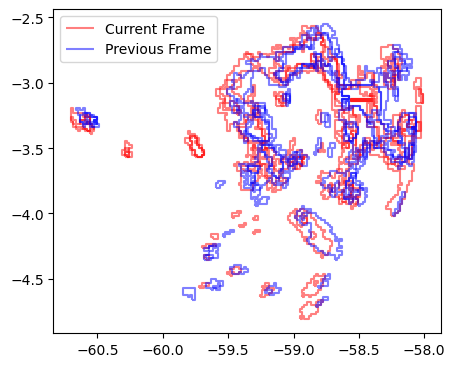

In [11]:
# Visualize the features and see have a visual overlap between the geometries
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cur_frame.boundary.plot(ax=ax, color='red', alpha=0.5, label='Current Frame')
prev_frame.boundary.plot(ax=ax, color='blue', alpha=0.5, label='Previous Frame')
plt.legend( loc='upper left')

In [12]:
# Display the first 5 rows of the current frame
display(cur_frame.head()[['timestamp','geometry']])

timestamp                                           geometry
0 2014-08-16 10:12:00  POLYGON ((-58.95268 -4.80363, -58.95268 -4.785...
1 2014-08-16 10:12:00  POLYGON ((-59.2561 -4.64255, -59.2561 -4.62465...
2 2014-08-16 10:12:00  POLYGON ((-59.72015 -4.57095, -59.72015 -4.553...
3 2014-08-16 10:12:00  POLYGON ((-59.23825 -4.57095, -59.23825 -4.553...
4 2014-08-16 10:12:00  POLYGON ((-58.93484 -4.64255, -58.93484 -4.624...

In [13]:
# Display the first 5 rows of the previous frame
display(prev_frame.head()[['timestamp','geometry']])

timestamp                                           geometry
0 2014-08-16 10:00:00  POLYGON ((-58.82775 -4.71414, -58.82775 -4.696...
1 2014-08-16 10:00:00  POLYGON ((-59.7737 -4.66044, -59.7737 -4.62465...
2 2014-08-16 10:00:00  POLYGON ((-59.18471 -4.62465, -59.18471 -4.606...
3 2014-08-16 10:00:00  POLYGON ((-59.63091 -4.58885, -59.63091 -4.570...
4 2014-08-16 10:00:00  POLYGON ((-58.8099 -4.57095, -58.8099 -4.55305...

To demonstrate one of the operations performed in the algorithm, below is the GeoPandas sjoin function that checks the overlaps between the two GeoDataframes. 
Note that the return of the function will be another GeoDataframe, however only the index and index_right columns are of interest to us, 
as in these columns we have the information we need to make the associations between the geometries of the consecutive time clusters.
In addition to the overlap operation, there are several others that can be seen at:
https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates

In [14]:
# Perform the spatial join between the previous and current frame
overlaps = gpd.sjoin(cur_frame, prev_frame, how='inner', predicate='overlaps')[['index_right']].reset_index()
# Ex: index (cur_frame) 0 overlaps with index_right 0 (prev_franme)
overlaps

index  index_right
0        0            0
1        1            2
2        2            3
3        4            4
4        5            5
..     ...          ...
136     68           38
137     68           57
138     69           18
139     69           39
140     69           58

[141 rows x 2 columns]

In addition, the spatial operations module also has additional vector extraction methods. These methods are covered in the work https://doi.org/10.3390/rs14215408

To activate the methods just add the flags to the name_list.

In [15]:
# Add correction methods
name_list['spl_correction'] = True # It is used to perform the correction at Splitting events
name_list['mrg_correction'] = True # It is used to perform the correction at Merging events
name_list['inc_correction'] = True # It is used to perform the correction using Inner Core vectors
name_list['opt_correction'] = True # It is used to perform the correction using the Optical Flow method
name_list['elp_correction'] = True # It is used to perform the correction using the Ellipse method
name_list['validation'] = True # It is used to perform the validation of the correction methods

In [16]:
# Run the spatial_operations function (Note: If you are running this notebook using MacOS, you may need to set parallel=False)
pyfortracc.spatial_operations(name_list, read_function, parallel=False)

Spatial Operations:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:01:11 Remaining:<00:00]


In [17]:
# Read the spatial parquet files
spatial = sorted(glob.glob(name_list['output_path'] + '/track/processing/spatial/*.parquet'))
spatial_df = pd.concat(pd.read_parquet(f) for f in spatial)
display(spatial_df.tail())

status  threshold_level  inside_clusters  past_idx inside_idx merge_idx  \
18    CON                2              NaN      12.0       None      None   
19    NEW                2              NaN       NaN       None      None   
20    NEW                2              NaN       NaN       None      None   
21    CON                2              NaN      14.0       None      None   
22    NEW                2              NaN       NaN       None      None   

    split_pr_idx split_cr_idx    overlap within  ... u_inc v_inc     u_opt  \
18           NaN         None  34.285714   None  ...   NaN   NaN -0.057045   
19           NaN         None        NaN   None  ...   NaN   NaN -0.064725   
20           NaN         None        NaN   None  ...   NaN   NaN -0.032292   
21           NaN         None  56.000000   None  ...   NaN   NaN -0.062565   
22           NaN         None        NaN   None  ...   NaN   NaN -0.032656   

       v_opt     u_elp     v_elp     u_noc     v_noc       far  method  
18 -0.014866 -0.036013 -0.024529 -0.036013 -0.024529  0.407407     noc  
19 -0.023200       NaN       NaN       NaN       NaN  1.000000     noc  
20  0.017446       NaN       NaN       NaN       NaN  1.000000     noc  
21 -0.015033 -0.062779 -0.026051 -0.062779 -0.026051  0.881356     noc  
22  0.013108       NaN       NaN       NaN       NaN  1.000000     noc  

[5 rows x 32 columns]

##### Cluster Link

The cluster connection module makes the association between consecutive time tables by associating the cluster indices that were identified by the spatial operations module.

In [18]:
# Run the cluster_linking function
pyfortracc.cluster_linking(name_list)

Cluster linking:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:02 Remaining:<00:00]


Bellow we show how cluster link works. Set two spatial parquets from consecutive timestamps. And show the association between them based on indexes.

In [19]:
# Read current and previous frames
cur_frame = pd.read_parquet('output/track/processing/spatial/20140816_1212.parquet')
prv_frame = pd.read_parquet('output/track/processing/spatial/20140816_1200.parquet')

In [20]:
# Current Frame
cur_frame.dropna(subset=['past_idx']).head()

status  threshold_level  inside_clusters  past_idx  \
4       CON                0              NaN       4.0   
8       CON                0             11.0       7.0   
9       CON                0              3.0       9.0   
10  NEW/SPL                0              NaN      12.0   
11      CON                0              2.0      11.0   

                                      inside_idx merge_idx  split_pr_idx  \
4                                           None      None           NaN   
8   [32, 33, 36, 37, 38, 43, 71, 72, 74, 76, 77]      None           NaN   
9                                   [42, 45, 79]      None           NaN   
10                                          None      None          12.0   
11                                      [48, 80]      None           NaN   

   split_cr_idx     overlap within  ...     u_inc     v_inc u_opt  v_opt  \
4          None   36.363636   None  ...       NaN       NaN   NaN    NaN   
8          None   42.288557   None  ... -0.040582  0.021194   NaN    NaN   
9          None   34.444444   None  ... -0.046809  0.007063   NaN    NaN   
10         None  100.000000   True  ...       NaN       NaN   NaN    NaN   
11         None   67.647059   None  ... -0.028131  0.012977   NaN    NaN   

       u_elp     v_elp     u_noc     v_noc       far  method  
4  -0.064671  0.016853 -0.064671  0.016853  1.000000     noc  
8  -0.030445  0.092496 -0.030445  0.092496  0.437318     inc  
9  -0.046809  0.007063 -0.046809  0.007063  0.534483     noc  
10  0.025131 -0.084522  0.025131 -0.084522  0.934884     noc  
11 -0.031077  0.013231 -0.031077  0.013231  0.800000     noc  

[5 rows x 32 columns]

In [21]:
# Previous frame
prv_frame.loc[cur_frame['past_idx'].dropna().astype(int).values].head()

status  threshold_level  inside_clusters  past_idx        inside_idx  \
4     NEW                0              NaN       NaN              None   
7     SPL                0              4.0       6.0  [28, 29, 30, 32]   
9     CON                0              3.0       8.0      [34, 35, 66]   
12    CON                0              3.0      11.0      [38, 39, 40]   
11    CON                0              2.0      10.0          [37, 72]   

   merge_idx  split_pr_idx split_cr_idx    overlap within  ...     u_inc  \
4       None           NaN         None        NaN   None  ...       NaN   
7       None           NaN         None  44.535519   None  ... -0.063314   
9       None           NaN         None  53.448276   None  ... -0.043407   
12      None           NaN         None  59.030837   None  ... -0.031909   
11      None           NaN         None  70.000000   None  ... -0.024769   

       v_inc u_opt  v_opt     u_elp     v_elp     u_noc     v_noc       far  \
4        NaN   NaN    NaN       NaN       NaN       NaN       NaN  1.000000   
7  -0.004529   NaN    NaN -0.095394  0.000637 -0.095394  0.000637  0.446367   
9   0.016077   NaN    NaN -0.053623  0.032569 -0.053623  0.032569  0.709677   
12 -0.028484   NaN    NaN -0.040166 -0.036414 -0.040166 -0.036414  0.296804   
11  0.011403   NaN    NaN -0.018173  0.007539 -0.018173  0.007539  0.409091   

    method  
4      noc  
7      inc  
9      inc  
12     noc  
11     noc  

[5 rows x 32 columns]

In [22]:
# Show the linking results
linked = sorted(glob.glob(name_list['output_path'] + '/track/processing/linked/*.parquet'))
linking_df = pd.concat(pd.read_parquet(f) for f in linked)
linking_df.loc[linking_df['trajectory'] != 'LINESTRING EMPTY'].tail()

cindex    uid      iuid  threshold_level  lifetime  \
11    3774  676.0  676.2690                1      24.0   
15    3778  480.0  480.6020                1      12.0   
16    3779  480.0  480.9410                1     132.0   
18    3781  676.0  676.0832                2      12.0   
21    3784  480.0  480.0466                2     132.0   

                                           trajectory  
11  LINESTRING (-59.52301320256508 -4.971232289702...  
15  LINESTRING (-60.98620736063504 -1.689640555655...  
16  LINESTRING (-60.579699018794244 -1.81843835001...  
18  LINESTRING (-59.548750321934435 -5.01255653169...  
21  LINESTRING (-60.57329468879667 -1.815821221102...

#### Concatenate 

All features in one single file per timestamp, and create the Tracking Table.


In [23]:
# Concatenate the features and spatial dataframes
pyfortracc.concat(name_list, clean=True)

Concatenating:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:00 Remaining:<00:00]


#### Compute Duration 

This module computes the duration of individual systems after the linking process. 
At this proccess, the algorithm calculates the duration of each system in minutes, and the location of genesis and lysis of each system.

In [24]:
pyfortracc.post_processing.compute_duration(name_list)

Computing duration:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:00 Remaining:<00:00]


The tracking table is the generalized output entity of the algorithm, it is formed by the set of files (.parquet) that are located in the output directory of the same name ('output_path/trackingtable'). The information obtained in the tracking process is stored in a tabular format, and is organized according to the tracking time. Listed below are the names of the columns (output variables) and what they represent.

- Each row of tracking table is related to a cluster at its corresponding threshold level. 
- The information spans from unique identifiers and descriptive statistics to geometric properties and temporal features. 
- The Tracking table structure provides a comprehensive view of grouped entities, facilitating analysis and understanding of patterns across different threshold levels.

Tracking table columns:

*   **timestamp** (datetime64[us]): Temporal information of cluster.
*   **uid** (float64): Unique idetifier of cluster.
*   **iuid** (float64): Internal Unique idetifier of cluster.
*   **threshold_level** (int64): Level of threshold.
*   **threshold** (float64): Specific threshold.
*   **status** (object): Entity status (NEW, CONTINUOUS, SPLIT, MERGE, SPLIT/MERGE)
*   **u_, v_** (float64): Vector components.
*   **inside_clusters** (object): Number of inside clusters.
*   **size** (int64): Cluster size in pixels.
*   **min, mean, max, std** (float64): Descriptive statistics.
*   **delta_time** (timedelta64[us]): Temporal variation.
*   **file** (object): Associated file name.
*   **array_y, array_x** (object): Cluster array coordinates.
*   **vector_field** (object): Associated vector field.
*   **trajectory** (object): Cluster's trajectory.
*   **geometry** (object):  Boundary geometric representation of the cluster.
*   **lifetime** (int64): Cluster lifespan in minutes.
*   **duration** (int64): Cluster duration in minutes.
*   **genesis** (int64): Cluster genesis, with genesis: 1, active: 0, and death: -1.

#### Resumed track Function

Entery process we show above, is a workflow how the algorithm works. However, the track function is a simplified way to run the algorithm. And the way to use a simplified way is:

In [25]:
# Track function
pyfortracc.track(name_list, read_function, parallel=True)

Features Extraction:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:02 Remaining:<00:00]


Spatial Operations:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:13 Remaining:<00:00]


Cluster linking:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:01 Remaining:<00:00]


Concatenating:


100%|█████████████████████████████████| 61/61 +                     [Elapsed:00:00 Remaining:<00:00]


In [26]:
# The tracking table is saved in the output path
tracking_files = sorted(glob.glob(name_list['output_path'] + '/track/trackingtable/*.parquet'))
tracking_table = pd.concat(pd.read_parquet(f) for f in tracking_files)
display(tracking_table.tail())

timestamp    uid      iuid  threshold_level  threshold  \
cindex                                                                    
3781   2014-08-16 22:00:00  676.0  676.0951                2       35.0   
3782   2014-08-16 22:00:00  734.0  734.0232                2       35.0   
3783   2014-08-16 22:00:00    NaN       NaN                2       35.0   
3784   2014-08-16 22:00:00  480.0  480.0610                2       35.0   
3785   2014-08-16 22:00:00  737.0  737.0792                2       35.0   

       status  size  lifetime    expansion        min  ...       far  method  \
cindex                                                 ...                     
3781      CON    35      12.0   358.422939  35.017868  ...  0.407407     noc   
3782      NEW    16       0.0          NaN  35.982376  ...  1.000000     noc   
3783      NEW     3       0.0          NaN  36.910580  ...  1.000000     noc   
3784      CON    24     132.0 -1171.352075  35.006462  ...  0.881356     noc   
3785      NEW    12       0.0          NaN  36.390186  ...  1.000000     noc   

        u_spl  v_spl  u_mrg  v_mrg     u_opt     v_opt     u_elp     v_elp  
cindex                                                                      
3781      NaN    NaN    NaN    NaN -0.057045 -0.014866 -0.036013 -0.024529  
3782      NaN    NaN    NaN    NaN -0.064725 -0.023200       NaN       NaN  
3783      NaN    NaN    NaN    NaN -0.032292  0.017446       NaN       NaN  
3784      NaN    NaN    NaN    NaN -0.062565 -0.015033 -0.062779 -0.026051  
3785      NaN    NaN    NaN    NaN -0.032656  0.013108       NaN       NaN  

[5 rows x 35 columns]

#### Explore the results in tracking table

At this exemple we will show the systems where max duration at the tracking table for the threshold 20.0 dBZ.


In [27]:
# Get two maxlifetime clusters from the track_table
maxlifetime = 2
max_lifetimes = tracking_table.groupby('uid').size().nlargest(maxlifetime).index.values
max_clusters = tracking_table[tracking_table['uid'].isin(max_lifetimes)]
print('The clusters with the highest lifetime are the uids: {}'.format(max_lifetimes))

The clusters with the highest lifetime are the uids: [280.  81.]


Visualize the maxlifetime system in the tracking table.

In [28]:
# Plot the tracking data for periods of time. Note: If the min and max value is a larger time interval, 
# the plot will be slower
pyfortracc.plot_animation(read_function=read_function, # Read function
                          name_list=name_list, # Name list dictionary
                          uid_list=max_lifetimes.tolist(), # List of uids
                          start_timestamp = max_clusters['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S'), 
                          end_timestamp= max_clusters['timestamp'].max().strftime('%Y-%m-%d %H:%M:%S'),
                          cbar_title='dBZ', # Colorbar title
                          threshold_list=[20], # Threshold list
                          trajectory=True, # Plot the trajectory
                          smooth_trajectory=True, # Smooth the trajectory
                          max_val=60, # Maximum value for the colorbar
                          min_val=20, # Minimum value for the colorbar
                          info_cols=['uid','method','far'],
                          vector=True, # Plot the vector
                          vector_scale=0.1, # Vector scale
                          )

Generating animation... 